
![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/PPTX_TABLE.ipynb)

# **Example of extracting table data from Microsoft PPT documents**

## 🔎**Colab Setup** 

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)



## **🔎Import OCR transformers**

In [2]:
import sparkocr
import sys
from pyspark.sql import SparkSession
from sparkocr import start
import base64
from sparkocr.transformers import *
from pyspark.ml import PipelineModel, Pipeline
from pyspark.sql import functions as F
from pyspark.sql.functions import  col
from sparkocr.enums import *
from termcolor import colored
from sparkocr.utils import display_images, display_images, display_pdf, display_tables

In [3]:
# Start spark
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION
                       )

spark

Spark version: 3.0.2
Spark NLP version: 3.4.4
Spark OCR version: 3.12.0



In [4]:
spark.conf.set("spark.sql.legacy.allowUntypedScalaUDF", True)
print(spark.conf.get("spark.sql.legacy.allowUntypedScalaUDF"))

true


## **🔎Read PPT document as binary file**

In [5]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/pptx_table.pptx

In [6]:
pptx_example_df = spark.read.format("binaryFile").load('/content/pptx_table.pptx').cache()
pptx_example_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/ppt...|2022-06-09 12:58:...| 43515|[50 4B 03 04 14 0...|
+--------------------+--------------------+------+--------------------+




    Image #0:
    Origin: file:/content/pptx_table.pptx
    Resolution: 300 dpi
    Width: 2479 px
    Height: 3508 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


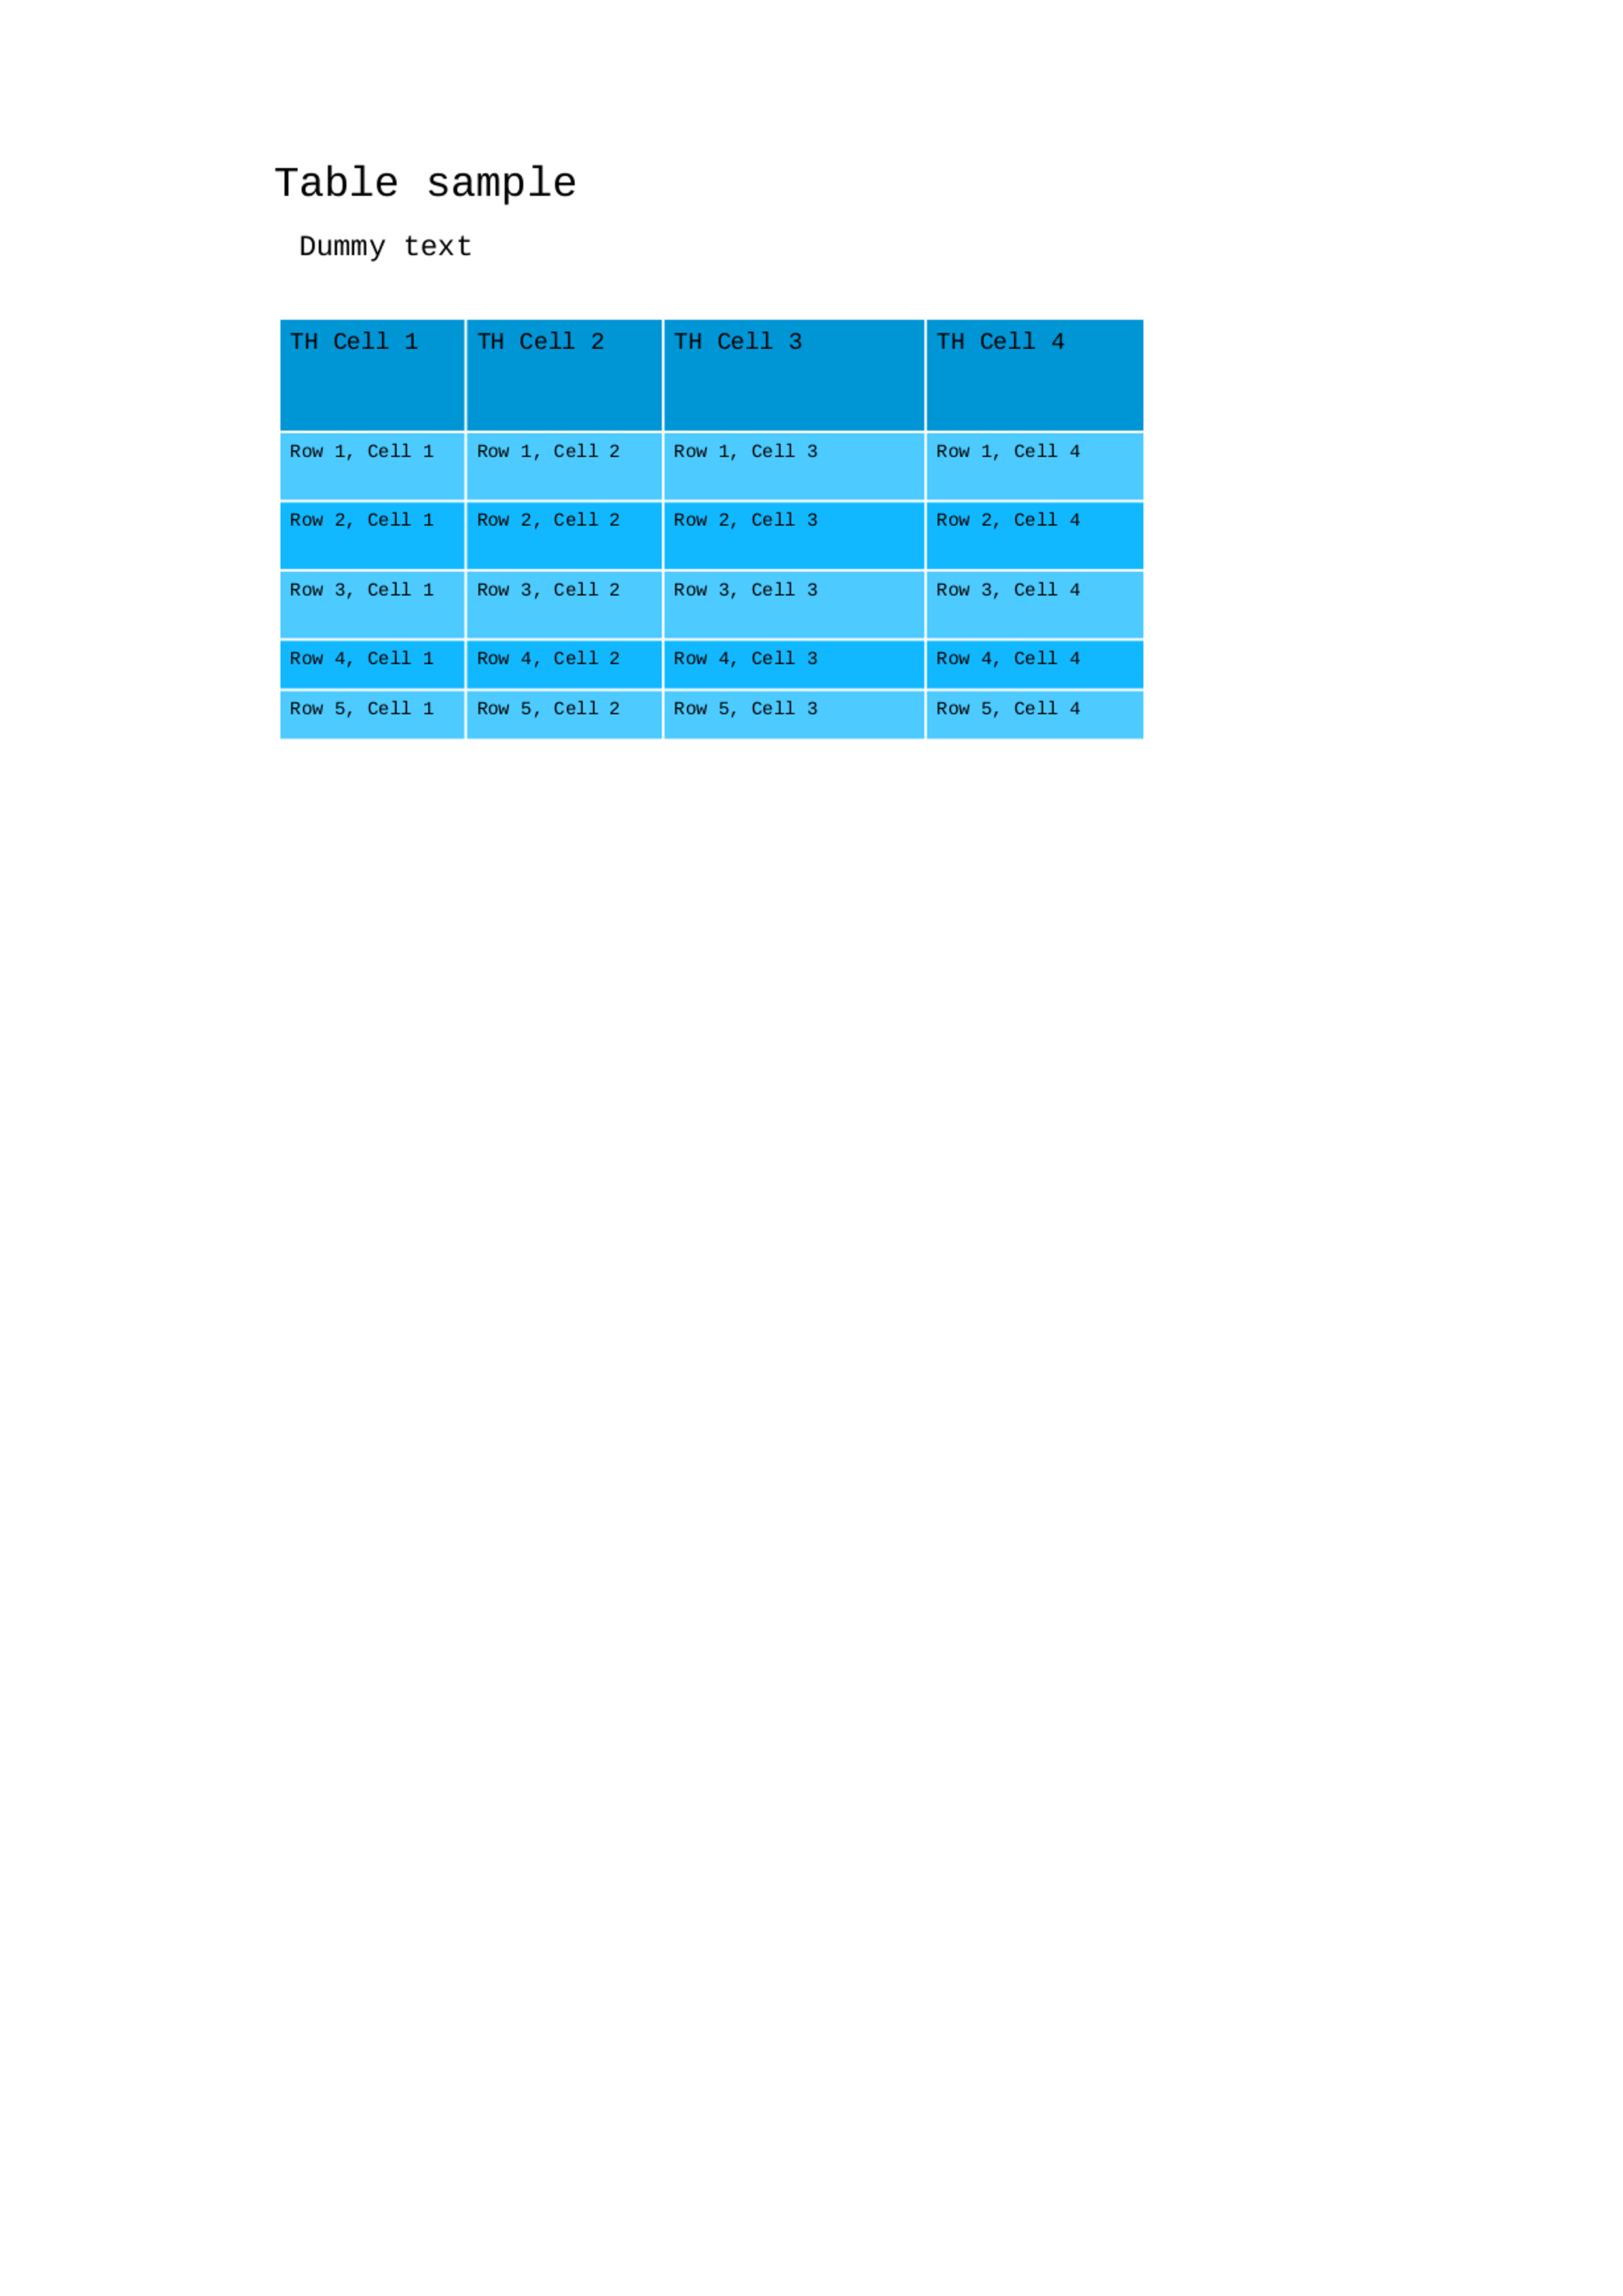

In [7]:
#Read PPT document as binary file¶

# convert PPT to PDF
pdf_df = PptToPdf() \
    .setOutputCol("content") \
    .transform(pptx_example_df)

# Convert PDF to image for display
image_df = PdfToImage() \
    .setImageType(ImageType.TYPE_3BYTE_BGR) \
    .transform(pdf_df)

display_images(image_df)

## **🔎Extracting table data from PPT documents**

In [8]:
#Extract tables from PPT using PptToTextTable transformer¶

ppt_to_table = PptToTextTable()
ppt_to_table.setInputCol("content")
ppt_to_table.setOutputCol("table")

result = ppt_to_table.transform(pptx_example_df).cache()

In [9]:
result.show()

+--------------------+--------------------+------+--------------------+---------+-------+
|                path|    modificationTime|length|               table|exception|pagenum|
+--------------------+--------------------+------+--------------------+---------+-------+
|file:/content/ppt...|2022-06-09 12:58:...| 43515|[[0, 0, 30.0, 168...|     null|      0|
+--------------------+--------------------+------+--------------------+---------+-------+



In [10]:
display_tables(result)

Filename: pptx_table.pptx
Page:     0
Table:    0


12:59:15, INFO NumExpr defaulting to 2 threads.


,col0,col1,col2,col3
0,TH Cell 1,TH Cell 2,TH Cell 3,TH Cell 4
1,"Row 1, Cell 1","Row 1, Cell 2","Row 1, Cell 3","Row 1, Cell 4"
2,"Row 2, Cell 1","Row 2, Cell 2","Row 2, Cell 3","Row 2, Cell 4"
3,"Row 3, Cell 1","Row 3, Cell 2","Row 3, Cell 3","Row 3, Cell 4"
4,"Row 4, Cell 1","Row 4, Cell 2","Row 4, Cell 3","Row 4, Cell 4"
5,"Row 5, Cell 1","Row 5, Cell 2","Row 5, Cell 3","Row 5, Cell 4"
